# Imports

In [1]:
%%capture

import math
import db_func
import pandas as pd
import numpy as np
from tqdm import notebook
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, show
import matplotlib.pyplot as plt
from datetime import date, datetime
from tqdm.notebook import tqdm
import re

#notebook.tqdm(looping)

try:
    %load_ext autotime
    %load_ext jupyterlab_notify
except:
    !pip3 install ipython-autotime
    %load_ext autotime

time: 1.35 s (started: 2021-09-05 18:50:44 -04:00)


## Get Database Connection

In [ ]:
conn = db_func.get_conn()

# Preprocessing

match_df: The final processed dataset to be used in the machine learning models 

## Populate Dataframes From Database

### SQL Query

In [ ]:
match_query = '''SELECT
                    m.match_id,  m.away_id, m.home_id,
                    m.date, m.away_pts, m.home_pts, m.playoff_game,
                    h_ml.home_ml, a_ml.away_ml,
                    h_ps.home_spread, a_ps.away_spread,
                    h_ps.home_ps_odds, a_ps.away_ps_odds,
                    over.over, under.under, ou.spread
                FROM match AS m
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS home_ml,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 1 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.home_id
                    GROUP BY m.match_id
                ) AS h_ml ON m.match_id = h_ml.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS away_ml,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 1 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.away_id
                    GROUP BY m.match_id
                ) AS a_ml ON m.match_id = a_ml.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS home_ps_odds,
                        AVG(spread) AS home_spread,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 2 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.home_id
                    GROUP BY m.match_id
                ) AS h_ps ON m.match_id = h_ps.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS away_ps_odds,
                        AVG(spread) AS away_spread,
                        m.match_id AS match_id
                    FROM
                        odds AS o, team AS t1, team as t2,
                        match AS m
                    WHERE
                        o.bet_type_id = 2 AND
                        o.match_id = m.match_id AND
                        o.team_id = m.away_id
                    GROUP BY m.match_id
                ) AS a_ps ON m.match_id = a_ps.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS under,
                        m.match_id AS match_id
                    FROM
                        odds AS o, match AS m
                    WHERE
                        o.bet_type_id = 3 AND
                        o.over_under = 'under' AND
                        o.match_id = m.match_id
                    GROUP BY m.match_id
                ) AS under ON m.match_id = under.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(decimal_odds) AS over,
                        m.match_id AS match_id
                    FROM
                        odds AS o, match AS m
                    WHERE
                        o.bet_type_id = 3 AND
                        o.over_under = 'over' AND
                        o.match_id = m.match_id
                    GROUP BY m.match_id
                ) AS over ON m.match_id = over.match_id
                LEFT OUTER JOIN
                (
                    SELECT
                        AVG(spread) AS spread,
                        m.match_id AS match_id
                    FROM
                        odds AS o, match AS m
                    WHERE
                        o.bet_type_id = 3 AND
                        o.match_id = m.match_id
                    GROUP BY m.match_id
                ) AS ou ON m.match_id = ou.match_id
                ORDER BY date ASC
                '''
#                    WHERE m.date >= DATE('2007-10-30')

season_query = '''SELECT *
                  FROM season'''
player_performance_query = '''SELECT p.*, m.date
                              FROM player_performance as p, match as m
                              WHERE m.match_id = p.match_id
                              ORDER BY date ASC'''
team_query = '''SELECT * 
                FROM team_name'''
injury_query = '''SELECT * 
                FROM injury'''

match_df = pd.read_sql(match_query, conn)
#match_df.set_index('match_id', inplace=True)
season_df = pd.read_sql(season_query, conn)
pp_df = pd.read_sql(player_performance_query, conn)
team_df = pd.read_sql(team_query, conn)
injury_df = pd.read_sql(injury_query, conn)
match_df['date'] = match_df['date'].map(lambda x: datetime(x.year, x.month, x.day))
pp_df['date'] = pp_df['date'].map(lambda x: datetime(x.year, x.month, x.day))
season_df['start_date'] =season_df['start_date'].map(lambda x: datetime(x.year, x.month, x.day))
season_df['end_date'] = season_df['end_date'].map(lambda x: datetime(x.year, x.month, x.day))

Set the season for each match

In [ ]:
def get_season(date):
    return season_df[(season_df['start_date'] <= date) &
                     (season_df['end_date'] >= date)]['season'].values[0]

In [ ]:
match_df['season'] = match_df['date'].map(get_season)
pp_df['season'] = pp_df['date'].map(get_season)

Only matches from seasons 2008-2021 will be used 

# Feature Engineering

## Margin of Victory/Loss (MOVL) with respect to the home team

In [ ]:
match_df['movl'] = match_df['home_pts'] - match_df['away_pts']
match_df['h_win'] = match_df['movl'].map(lambda x: 0 if x < 0 else 1)

## Team Elo Rating

Each team starts at 1500 elo

In [ ]:
match_df['home_elo'] = 1500.0
match_df['away_elo'] = 1500.0

### Get the previous match of each team to aid elo calculation

In [ ]:
def get_prev_match(date, team_id, match_df):
    return match_df[(match_df["date"] < date) &
                    ((match_df["home_id"] == team_id) |
                     (match_df["away_id"] == team_id))].tail(1)

### Team elo calculation

In [ ]:
def get_prev_elo(team_id, season, prev_match):

    if prev_match.empty:
        prev_elo = 1500.0
    elif team_id == prev_match['home_id'].values[0]:
        prev_elo = prev_match['home_elo'].values[0]
    elif team_id == prev_match['away_id'].values[0]:
        prev_elo = prev_match['away_elo'].values[0]
    else: 
        print('err')

    if (not prev_match.empty and
            (prev_match['season'].values[0]
             != season)):
        prev_elo = prev_elo * 0.75 + 1505 * 0.25
    return prev_elo


def update_elo(home_elo, away_elo, movl):
    elo_diff = home_elo + 100.0 - away_elo
    if movl > 0:
        h_s = 1.0
        a_s = 0.0
        multiplier = ((movl+3)**(0.8))/(7.5+0.006*elo_diff)

    else:
        h_s = 0.0
        a_s = 1.0
        multiplier = ((-movl+3)**(0.8))/(7.5+0.006*(-elo_diff))
        
    exp_h_s = 1.0 / (1.0 + 10.0 ** (-elo_diff/400.0))
    exp_a_s = 1.0 - exp_h_s
    
    k = 20.0 * multiplier

    new_home_elo = home_elo + k * (h_s - exp_h_s)
    new_away_elo = away_elo + k * (a_s - exp_a_s)

    return (new_home_elo, new_away_elo)

In [ ]:
for idx, row in tqdm(match_df.iterrows(), total=match_df.shape[0]):
    prev_h_match = get_prev_match(row['date'], row['home_id'], match_df)
    prev_a_match = get_prev_match(row['date'], row['away_id'], match_df)
    
    prev_h_elo = get_prev_elo(
        row['home_id'], row['season'], prev_h_match)
    prev_a_elo = get_prev_elo(
        row['away_id'], row['season'], prev_a_match)    
    
    new_elos = update_elo(prev_h_elo, prev_a_elo, row['movl'])
    match_df.at[idx, 'home_elo'] = new_elos[0]
    match_df.at[idx, 'away_elo'] = new_elos[1]
    
    match_df.at[idx, 'prev_home_elo'] = prev_h_elo
    match_df.at[idx, 'prev_away_elo'] = prev_a_elo

In [ ]:
match_df = match_df[match_df['date'] >= datetime(2007,10,30)].copy()

In [ ]:
def plot_elo(team_id):
    output_notebook()
    plot = figure(title="Historical Elo Rating", x_axis_label="Date", y_axis_label="Elo", 
                  x_axis_type = 'datetime', plot_width=800, plot_height=500)

    y = match_df[(match_df['away_id'] == team_id) | (match_df['home_id'] == team_id)]
    x = y['date']
    y = y.apply(lambda x: x['home_elo'] if x['home_id'] == team_id else x['away_elo'], axis=1)
    
    team_name = team_df[team_df['team_id'] == team_id]['team_name'].head(1).values[0]
    plot.circle(x, y, legend_label = team_name, line_color = 'blue', line_width = 1)

    handle = show(plot, notebook_handle=True)

    # Update the plot title in the earlier cell
    push_notebook(handle=handle)

## Player elo rating

In [ ]:
def get_prev_player_match(date, player_id, pp_df):
    return pp_df[(pp_df['date'] < date) & 
                (pp_df['player_id'] == player_id)].tail(1)
def get_active_players(match_id, team_id, pp_df):
    return  pp_df[(pp_df['match_id'] == match_id) &
                      (pp_df['team_id'] == team_id) &
                  (pp_df['sp']>0)]

def get_complete_roster(match_id, team_id, match_df):
    return  pp_df[(pp_df['match_id'] == match_id) &
                      (pp_df['team_id'] == team_id)]

In [ ]:
pp_df['post_elo'] = 1500
pp_df['prev_elo'] = 1500
for idx, row in tqdm(match_df.iterrows(), total=match_df.shape[0]):
    ## update prev_elo for all players
    all_home_players = get_complete_roster(row['match_id'], 
                                       row['home_id'], pp_df)
    all_away_players = get_complete_roster(row['match_id'], 
                                       row['away_id'], pp_df)

    for p_idx, player in pd.concat([all_home_players, all_away_players]).iterrows():
        prev_player_match = get_prev_player_match(player['date'], player['player_id'], pp_df)
        if prev_player_match.empty:
            prev_elo = 1500

        else:
            prev_elo = prev_player_match['post_elo']
            #print(prev_player_match['season'].values[0],player['season'])
            if (prev_player_match['season'].values[0] != player['season']):
                #tmp = prev_elo
                prev_elo = prev_elo * 0.75 + 1505 * 0.25
                #print(tmp, prev_elo)
        pp_df.at[p_idx, 'prev_elo'] = prev_elo
        pp_df.at[p_idx, 'post_elo'] = prev_elo

    ## Update post_elo of players that played in current match
    home_players = get_active_players(row['match_id'], row['home_id'], pp_df)
    away_players = get_active_players(row['match_id'], row['away_id'], pp_df)

    injured_players = injury_df[row['match_id'] == injury_df['match_id']]    
    if not injured_players.empty:
        home_players = home_players[~home_players['player_id'].isin(injured_players['player_id'])]
        away_players = away_players[~away_players['player_id'].isin(injured_players['player_id'])]
    
    home_players_elo_sum = home_players['prev_elo'].sum()
    away_players_elo_sum = away_players['prev_elo'].sum()
    len_home_players = len(home_players)
    len_away_players = len(away_players)

    for p_idx, player in home_players.iterrows():
        opp_elo = away_players_elo_sum / len_away_players
#         opp_elo = away_players_elo_sum * 2 / len_away_players \
#             - (home_players_elo_sum - player['prev_elo']) / (len_home_players-1)
        new_elos = update_elo(player['prev_elo'], opp_elo, row['movl'])
        pp_df.at[p_idx, 'post_elo'] = new_elos[0]
    
    for p_idx, player in away_players.iterrows():
        opp_elo = home_players_elo_sum / len_home_players
#         opp_elo = home_players_elo_sum * 2 / len_home_players \
#             - (away_players_elo_sum - player['prev_elo']) / (len_away_players-1)
        new_elos = update_elo(opp_elo, player['prev_elo'], row['movl'])
        pp_df.at[p_idx, 'post_elo'] = new_elos[1]

    active_home_players = get_active_players(row['match_id'], row['home_id'], pp_df)
    active_away_players = get_active_players(row['match_id'], row['away_id'], pp_df)


    match_df.at[idx, 'prev_home_player_elo_avg'] = active_home_players['prev_elo'].sum()/len(active_home_players)
    match_df.at[idx, 'prev_away_player_elo_avg'] = active_away_players['prev_elo'].sum()/len(active_away_players)
 

In [ ]:
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE)

def plot_player_elo(player_id):
    output_notebook()
    plot = figure(title="Historical Elo Rating", 
                  x_axis_label="Date", 
                  y_axis_label="Elo", 
                  x_axis_type = 'datetime',
                  sizing_mode="stretch_width",)

    y = pp_df[pp_df['player_id'] == player_id]
    x = y['date']
    y = y['post_elo']
    
    team_name = str(player_id)
    plot.circle(x, y, legend_label = team_name, line_color = 'blue', line_width = 1)

    handle = show(plot, notebook_handle=True)

    # Update the plot title in the earlier cell
    push_notebook(handle=handle)

last_elo = pp_df.sort_values('date').groupby('player_id').tail(1)
last_elo = last_elo.sort_values('post_elo', ascending=False)
last_elo[last_elo['date']>datetime(2021,1,1)]['post_elo'].mean()
lebron = pp_df[(pp_df['player_id'] == 712)]

## Player Efficiency Rating (PER) Sum of Last 5 Games

The Hollinger Player Efficiency Rating for a player is defined as the sum of
the following stats


| Stat | Weight |
| --- | ----------- |
| FGM | 85.910 |
| Steals | 53.897 |
| 3PTM | 51.757 |
| FTM | 46.845 |
| Blocks | 39.190 |
| Offensive Rebounds | 39.190|
| Assists | 34.677 |
| Defensive Rebounds | 14.707 |
| Foul | -17.174 |
| FT Miss | -20.091 |
| FG Miss | -39.190 |
| Turnover | -53.897 |

 divided by (minutes played).

In [ ]:
def player_match_eff_rating(player):
    per = 0
    if player['sp'] > 0:
        per = player['fg'] * 85.910 
        + player['stl'] * 53.897
        + player['threep'] * 51.757
        + player['ft'] * 46.845
        + player['blk'] * 39.190 
        + player['orb'] * 39.190
        + player['drb'] * 34.677
        + player['ast'] * 14.707
        - player['pf'] * 17.174 
        - (player['fta'] - player['ft']) * 20.091 
        - (player['fga'] - player['fg']) * 39.190
        - player['tov'] * 53.897 
        
        per = per / (player['sp']/60.0)
    return per

def team_match_eff_rating(team_id, match_id, pp_df):
    df = pp_df[(pp_df['team_id'] == team_id) &
                        (pp_df['match_id'] == match_id)]
    return df['per'].sum()



In [ ]:
### To get head on head matches for an opponent, set opponent_id
def get_prev_matches(date, team_id, match_df, opponent_id = -1):
    if opponent_id != -1:
        return match_df[(match_df["date"] < date) &
                        (((match_df["home_id"] == team_id) & 
                          (match_df["away_id"] == opponent_id)) |
                         ((match_df["home_id"] == opponent_id) & 
                          (match_df["away_id"] == team_id)))]
    else:
        return match_df[(match_df["date"] < date) &
                    ((match_df["home_id"] == team_id) |
                     (match_df["away_id"] == team_id))]

def get_past_per_sum(team_id, prev_matches, i):
    if len(prev_matches) < i: 
        return None
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             x['home_per'] if x['home_id'] == team_id
                             else x['away_per'], axis=1)
    return prev_matches['res'].sum()    


In [ ]:
pp_df['per'] = pp_df.apply(player_match_eff_rating, axis=1)

match_df['away_per'] = match_df.apply(lambda x: team_match_eff_rating(
    x['away_id'],x['match_id'], pp_df), axis=1)
match_df['home_per'] = match_df.apply(lambda x: team_match_eff_rating(
    x['home_id'],x['match_id'], pp_df), axis=1)

match_df['past_5_home_per'] = match_df.apply(lambda x: 
                                get_past_per_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                    match_df).tail(5),
                                                5), axis=1)
match_df['past_5_away_per'] = match_df.apply(lambda x: 
                                get_past_per_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                    match_df).tail(5),
                                                5), axis=1)

match_df['past_3_hth_home_per'] = match_df.apply(lambda x: 
                                get_past_per_sum(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                     match_df,
                                                     x['away_id']
                                                    ).tail(3),
                                                3), axis=1)
match_df['past_3_hth_away_per'] = match_df.apply(lambda x: 
                                get_past_per_sum(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                     match_df,
                                                     x['home_id']
                                                    ).tail(3),
                                                3), axis=1)

## FG%, 3P%, FT%, ORB, DRB, TRB, TOV, AST, STL, BLK, DRTG, ORTG, EFG 

In [ ]:
from collections import defaultdict
d = defaultdict(list)
for idx, row in tqdm(match_df.iterrows(), total=match_df.shape[0]):
    home_players = get_active_players(row['match_id'], row['home_id'], pp_df)
    away_players = get_active_players(row['match_id'], row['away_id'], pp_df)
    d['home_bpm'].append(home_players['bpm'].sum())
    d['away_bpm'].append(away_players['bpm'].sum())
    
    d['home_fg'].append(home_players['fg'].sum())
    d['away_fg'].append(away_players['fg'].sum())
    d['home_fg_pct'].append(home_players['fg_pct'].mean())
    d['away_fg_pct'].append(away_players['fg_pct'].mean())
    
    d['home_3p'].append(home_players['threep'].sum())
    d['away_3p'].append(away_players['threep'].sum())
    d['home_3p_pct'].append(home_players['threep_pct'].mean())
    d['away_3p_pct'].append(away_players['threep_pct'].mean())
    
    d['home_ft'].append(home_players['ft'].sum())
    d['away_ft'].append(away_players['ft'].sum())
    d['home_ft_pct'].append(home_players['ft_pct'].mean())
    d['away_ft_pct'].append(away_players['ft_pct'].mean())
    
    d['home_orb'].append(home_players['orb'].sum())
    d['away_orb'].append(away_players['orb'].sum())
    d['home_orb_pct'].append(home_players['orb_pct'].mean())
    d['away_orb_pct'].append(away_players['orb_pct'].mean())
    
    d['home_drb'].append(home_players['drb'].sum())
    d['away_drb'].append(away_players['drb'].sum())
    d['home_drb_pct'].append(home_players['drb_pct'].mean())
    d['away_drb_pct'].append(away_players['drb_pct'].mean())
    
    d['home_trb'].append(home_players['trb'].sum())
    d['away_trb'].append(away_players['trb'].sum())
    d['home_trb_pct'].append(home_players['trb_pct'].mean())
    d['away_trb_pct'].append(away_players['trb_pct'].mean())
    
    d['home_tov'].append(home_players['tov'].sum())
    d['away_tov'].append(away_players['tov'].sum())
    d['home_tov_pct'].append(home_players['tov_pct'].mean())
    d['away_tov_pct'].append(away_players['tov_pct'].mean())
    
    d['home_ast'].append(home_players['ast'].sum())
    d['away_ast'].append(away_players['ast'].sum())
    d['home_ast_pct'].append(home_players['ast_pct'].mean())
    d['away_ast_pct'].append(away_players['ast_pct'].mean())
    
    d['home_stl'].append(home_players['stl'].sum())
    d['away_stl'].append(away_players['stl'].sum())
    d['home_stl_pct'].append(home_players['stl_pct'].mean())
    d['away_stl_pct'].append(away_players['stl_pct'].mean())
    
    d['home_blk'].append(home_players['blk'].sum())
    d['away_blk'].append(away_players['blk'].sum())
    d['home_blk_pct'].append(home_players['blk_pct'].mean())
    d['away_blk_pct'].append(away_players['blk_pct'].mean())
    
    d['home_drtg'].append(home_players['drtg'].mean())
    d['away_drtg'].append(away_players['drtg'].mean())
    
    d['home_ortg'].append(home_players['ortg'].mean())
    d['away_ortg'].append(away_players['ortg'].mean())
    
    d['home_efg_pct'].append(home_players['efg_pct'].mean())
    d['away_efg_pct'].append(away_players['efg_pct'].mean())
    
    

In [ ]:
df = pd.DataFrame(d)
match_df = pd.concat([match_df.reset_index(drop=True),
                      df.reset_index(drop=True)],axis=1)

## Calculating SMA and EMA 

In [ ]:
def ema(current, prev_ema, window_size, smoothing=2.0):
    k = smoothing / (1 + window_size)
    return current * k + prev_ema * (1-k)

In [ ]:
def get_prev_team_sum(team_id, home_col, prev_matches):
    away_col = home_col.replace('home', 'away')
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             x[home_col] if x['home_id'] == team_id
                             else x[away_col], axis=1)
    return prev_matches['res'].sum()

In [ ]:
window_size = 4
hth_window_size = 3
smoothing = 2

ema_h_features = [(f'prev_home_pts_ema{window_size}',       f'post_home_pts_ema{window_size}'),
                  (f'prev_home_bpm_ema{window_size}',       f'post_home_bpm_ema{window_size}'),
                  (f'prev_home_fg_ema{window_size}',        f'post_home_fg_ema{window_size}'),
                  (f'prev_home_fg_pct_ema{window_size}',    f'post_home_fg_pct_ema{window_size}'),
                  (f'prev_home_3p_ema{window_size}',        f'post_home_3p_ema{window_size}'),
                  (f'prev_home_3p_pct_ema{window_size}',    f'post_home_3p_pct_ema{window_size}'),
                  (f'prev_home_ft_ema{window_size}',        f'post_home_ft_ema{window_size}'),
                  (f'prev_home_ft_pct_ema{window_size}',    f'post_home_ft_pct_ema{window_size}'),
                  (f'prev_home_orb_ema{window_size}',       f'post_home_orb_ema{window_size}'),
                  (f'prev_home_orb_pct_ema{window_size}',   f'post_home_orb_pct_ema{window_size}'),
                  (f'prev_home_drb_ema{window_size}',       f'post_home_drb_ema{window_size}'),
                  (f'prev_home_drb_pct_ema{window_size}',   f'post_home_drb_pct_ema{window_size}'),
                  (f'prev_home_trb_ema{window_size}',       f'post_home_trb_ema{window_size}'),
                  (f'prev_home_trb_pct_ema{window_size}',   f'post_home_trb_pct_ema{window_size}'),
                  (f'prev_home_tov_ema{window_size}',       f'post_home_tov_ema{window_size}'),
                  (f'prev_home_tov_pct_ema{window_size}',   f'post_home_tov_pct_ema{window_size}'),
                  (f'prev_home_ast_ema{window_size}',       f'post_home_ast_ema{window_size}'),
                  (f'prev_home_ast_pct_ema{window_size}',   f'post_home_ast_pct_ema{window_size}'),
                  (f'prev_home_stl_ema{window_size}',       f'post_home_stl_ema{window_size}'),
                  (f'prev_home_stl_pct_ema{window_size}',   f'post_home_stl_pct_ema{window_size}'),
                  (f'prev_home_blk_ema{window_size}',       f'post_home_blk_ema{window_size}'),
                  (f'prev_home_blk_pct_ema{window_size}',   f'post_home_blk_pct_ema{window_size}'),
                  (f'prev_home_drtg_ema{window_size}',      f'post_home_drtg_ema{window_size}'),
                  (f'prev_home_ortg_ema{window_size}',      f'post_home_ortg_ema{window_size}'),
                  (f'prev_home_efg_pct_ema{window_size}',   f'post_home_efg_pct_ema{window_size}')]

ema_a_features = [(f[0].replace('home','away'), f[1].replace('home','away')) for f in ema_h_features]
sma_h_features = [(f[0].replace('ema','sma'), f[1].replace('ema','sma')) for f in ema_h_features]
sma_a_features = [(f[0].replace('home','away'), f[1].replace('home','away')) for f in sma_h_features]

ema_h_hth_features = [(f'prev_hth_home_pts_ema{hth_window_size}',       f'post_hth_home_pts_ema{hth_window_size}'),
                      (f'prev_hth_home_bpm_ema{hth_window_size}',       f'post_hth_home_bpm_ema{hth_window_size}'),
                      (f'prev_hth_home_fg_ema{hth_window_size}',        f'post_hth_home_fg_ema{hth_window_size}'),
                      (f'prev_hth_home_fg_pct_ema{hth_window_size}',    f'post_hth_home_fg_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_3p_ema{hth_window_size}',        f'post_hth_home_3p_ema{hth_window_size}'),
                      (f'prev_hth_home_3p_pct_ema{hth_window_size}',    f'post_hth_home_3p_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_ft_ema{hth_window_size}',        f'post_hth_home_ft_ema{hth_window_size}'),
                      (f'prev_hth_home_ft_pct_ema{hth_window_size}',    f'post_hth_home_ft_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_orb_ema{hth_window_size}',       f'post_hth_home_orb_ema{hth_window_size}'),
                      (f'prev_hth_home_orb_pct_ema{hth_window_size}',   f'post_hth_home_orb_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_drb_ema{hth_window_size}',       f'post_hth_home_drb_ema{hth_window_size}'),
                      (f'prev_hth_home_drb_pct_ema{hth_window_size}',   f'post_hth_home_drb_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_trb_ema{hth_window_size}',       f'post_hth_home_trb_ema{hth_window_size}'),
                      (f'prev_hth_home_trb_pct_ema{hth_window_size}',   f'post_hth_home_trb_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_tov_ema{hth_window_size}',       f'post_hth_home_tov_ema{hth_window_size}'),
                      (f'prev_hth_home_tov_pct_ema{hth_window_size}',   f'post_hth_home_tov_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_ast_ema{hth_window_size}',       f'post_hth_home_ast_ema{hth_window_size}'),
                      (f'prev_hth_home_ast_pct_ema{hth_window_size}',   f'post_hth_home_ast_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_stl_ema{hth_window_size}',       f'post_hth_home_stl_ema{hth_window_size}'),
                      (f'prev_hth_home_stl_pct_ema{hth_window_size}',   f'post_hth_home_stl_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_blk_ema{hth_window_size}',       f'post_hth_home_blk_ema{hth_window_size}'),
                      (f'prev_hth_home_blk_pct_ema{hth_window_size}',   f'post_hth_home_blk_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_drtg_ema{hth_window_size}',      f'post_hth_home_drtg_ema{hth_window_size}'),
                      (f'prev_hth_home_ortg_ema{hth_window_size}',      f'post_hth_home_ortg_ema{hth_window_size}'),
                      (f'prev_hth_home_efg_pct_ema{hth_window_size}',   f'post_hth_home_efg_pct_ema{hth_window_size}')]

ema_a_hth_features = [(f[0].replace('home','away'), f[1].replace('home','away')) for f in ema_h_hth_features]
sma_h_hth_features = [(f[0].replace('ema','sma'), f[1].replace('ema','sma')) for f in ema_h_hth_features]
sma_a_hth_features = [(f[0].replace('home','away'), f[1].replace('home','away')) for f in sma_h_hth_features]

print(sma_a_hth_features)


In [ ]:
d = defaultdict(list)
window_size = 4
hth_window_size = 3
smoothing = 2

ema_h_features = [(f'prev_home_pts_ema{window_size}',       f'post_home_pts_ema{window_size}'),
                  (f'prev_home_bpm_ema{window_size}',       f'post_home_bpm_ema{window_size}'),
                  (f'prev_home_fg_ema{window_size}',        f'post_home_fg_ema{window_size}'),
                  (f'prev_home_fg_pct_ema{window_size}',    f'post_home_fg_pct_ema{window_size}'),
                  (f'prev_home_3p_ema{window_size}',        f'post_home_3p_ema{window_size}'),
                  (f'prev_home_3p_pct_ema{window_size}',    f'post_home_3p_pct_ema{window_size}'),
                  (f'prev_home_ft_ema{window_size}',        f'post_home_ft_ema{window_size}'),
                  (f'prev_home_ft_pct_ema{window_size}',    f'post_home_ft_pct_ema{window_size}'),
                  (f'prev_home_orb_ema{window_size}',       f'post_home_orb_ema{window_size}'),
                  (f'prev_home_orb_pct_ema{window_size}',   f'post_home_orb_pct_ema{window_size}'),
                  (f'prev_home_drb_ema{window_size}',       f'post_home_drb_ema{window_size}'),
                  (f'prev_home_drb_pct_ema{window_size}',   f'post_home_drb_pct_ema{window_size}'),
                  (f'prev_home_trb_ema{window_size}',       f'post_home_trb_ema{window_size}'),
                  (f'prev_home_trb_pct_ema{window_size}',   f'post_home_trb_pct_ema{window_size}'),
                  (f'prev_home_tov_ema{window_size}',       f'post_home_tov_ema{window_size}'),
                  (f'prev_home_tov_pct_ema{window_size}',   f'post_home_tov_pct_ema{window_size}'),
                  (f'prev_home_ast_ema{window_size}',       f'post_home_ast_ema{window_size}'),
                  (f'prev_home_ast_pct_ema{window_size}',   f'post_home_ast_pct_ema{window_size}'),
                  (f'prev_home_stl_ema{window_size}',       f'post_home_stl_ema{window_size}'),
                  (f'prev_home_stl_pct_ema{window_size}',   f'post_home_stl_pct_ema{window_size}'),
                  (f'prev_home_blk_ema{window_size}',       f'post_home_blk_ema{window_size}'),
                  (f'prev_home_blk_pct_ema{window_size}',   f'post_home_blk_pct_ema{window_size}'),
                  (f'prev_home_drtg_ema{window_size}',      f'post_home_drtg_ema{window_size}'),
                  (f'prev_home_ortg_ema{window_size}',      f'post_home_ortg_ema{window_size}'),
                  (f'prev_home_efg_pct_ema{window_size}',   f'post_home_efg_pct_ema{window_size}')]

ema_a_features = [(f[0].replace('home','away'), f[1].replace('home','away')) for f in ema_h_features]
sma_h_features = [(f[0].replace('ema','sma'), f[1].replace('ema','sma')) for f in ema_h_features]
sma_a_features = [(f[0].replace('home','away'), f[1].replace('home','away')) for f in sma_h_features]

ema_h_hth_features = [(f'prev_hth_home_pts_ema{hth_window_size}',       f'post_hth_home_pts_ema{hth_window_size}'),
                      (f'prev_hth_home_bpm_ema{hth_window_size}',       f'post_hth_home_bpm_ema{hth_window_size}'),
                      (f'prev_hth_home_fg_ema{hth_window_size}',        f'post_hth_home_fg_ema{hth_window_size}'),
                      (f'prev_hth_home_fg_pct_ema{hth_window_size}',    f'post_hth_home_fg_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_3p_ema{hth_window_size}',        f'post_hth_home_3p_ema{hth_window_size}'),
                      (f'prev_hth_home_3p_pct_ema{hth_window_size}',    f'post_hth_home_3p_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_ft_ema{hth_window_size}',        f'post_hth_home_ft_ema{hth_window_size}'),
                      (f'prev_hth_home_ft_pct_ema{hth_window_size}',    f'post_hth_home_ft_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_orb_ema{hth_window_size}',       f'post_hth_home_orb_ema{hth_window_size}'),
                      (f'prev_hth_home_orb_pct_ema{hth_window_size}',   f'post_hth_home_orb_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_drb_ema{hth_window_size}',       f'post_hth_home_drb_ema{hth_window_size}'),
                      (f'prev_hth_home_drb_pct_ema{hth_window_size}',   f'post_hth_home_drb_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_trb_ema{hth_window_size}',       f'post_hth_home_trb_ema{hth_window_size}'),
                      (f'prev_hth_home_trb_pct_ema{hth_window_size}',   f'post_hth_home_trb_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_tov_ema{hth_window_size}',       f'post_hth_home_tov_ema{hth_window_size}'),
                      (f'prev_hth_home_tov_pct_ema{hth_window_size}',   f'post_hth_home_tov_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_ast_ema{hth_window_size}',       f'post_hth_home_ast_ema{hth_window_size}'),
                      (f'prev_hth_home_ast_pct_ema{hth_window_size}',   f'post_hth_home_ast_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_stl_ema{hth_window_size}',       f'post_hth_home_stl_ema{hth_window_size}'),
                      (f'prev_hth_home_stl_pct_ema{hth_window_size}',   f'post_hth_home_stl_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_blk_ema{hth_window_size}',       f'post_hth_home_blk_ema{hth_window_size}'),
                      (f'prev_hth_home_blk_pct_ema{hth_window_size}',   f'post_hth_home_blk_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_drtg_ema{hth_window_size}',      f'post_hth_home_drtg_ema{hth_window_size}'),
                      (f'prev_hth_home_ortg_ema{hth_window_size}',      f'post_hth_home_ortg_ema{hth_window_size}'),
                      (f'prev_hth_home_efg_pct_ema{hth_window_size}',   f'post_hth_home_efg_pct_ema{hth_window_size}')]

ema_a_hth_features = [(f[0].replace('home','away'), f[1].replace('home','away')) for f in ema_h_hth_features]
sma_h_hth_features = [(f[0].replace('ema','sma'), f[1].replace('ema','sma')) for f in ema_h_hth_features]
sma_a_hth_features = [(f[0].replace('home','away'), f[1].replace('home','away')) for f in sma_h_hth_features]


for idx, row in tqdm(match_df.iterrows(), total=match_df.shape[0]):
    prev_h_matches = get_prev_matches(row['date'], row['home_id'], match_df).tail(window_size)
    prev_a_matches = get_prev_matches(row['date'], row['away_id'], match_df).tail(window_size)
    
    prev_hth_matches = get_prev_matches(row['date'], row['home_id'], match_df, row['away_id']).tail(window_size)
    
    len_prev_h_matches = len(prev_h_matches)
    len_prev_a_matches = len(prev_a_matches)
    len_prev_hth_matches = len(prev_hth_matches)
    
    for i in range(len(ema_h_features)):
        h_feature = re.findall('home_.*_ema', ema_h_features[i][0])[0].replace('_ema', '')
        a_feature = h_feature.replace('home', 'away') 
        if not prev_hth_matches.empty:
            prev_match = prev_hth_matches.iloc[-1:]
            match_df.at[idx,sma_h_hth_features[i][0]] = get_prev_team_sum(row['home_id'], h_feature, prev_hth_matches)/len_prev_hth_matches    
            match_df.at[idx,sma_a_hth_features[i][0]] = get_prev_team_sum(row['away_id'], a_feature, prev_hth_matches)/len_prev_hth_matches    

            
            if len_prev_hth_matches < hth_window_size:
                match_df.at[idx,ema_h_hth_features[i][0]] = match_df.loc[idx,sma_h_hth_features[i][0]] 
                match_df.at[idx,ema_h_hth_features[i][1]] = (match_df.loc[idx,sma_h_hth_features[i][0]] \
                                                                     * len_prev_hth_matches + row[h_feature])/(len_prev_hth_matches + 1)
                match_df.at[idx,ema_a_hth_features[i][0]] = match_df.loc[idx,sma_a_hth_features[i][0]] 
                match_df.at[idx,ema_a_hth_features[i][1]] = (match_df.loc[idx,sma_a_hth_features[i][0]] \
                                                                     * len_prev_hth_matches + row[a_feature])/(len_prev_hth_matches + 1)
            else:
                match_df.at[idx,ema_h_hth_features[i][0]] = prev_match[ema_h_hth_features[i][1]] \
                                                        if prev_match['home_id'].values[0] == row['home_id'] \
                                                        else prev_match[ema_a_hth_features[i][1]]

                match_df.at[idx,ema_h_hth_features[i][1]] = ema(row[h_feature],  
                                                            match_df.loc[idx,ema_h_hth_features[i][0]], 
                                                            hth_window_size)
                match_df.at[idx,ema_a_hth_features[i][0]] = prev_match[ema_h_hth_features[i][1]] \
                                                        if prev_match['home_id'].values[0] == row['home_id'] \
                                                        else prev_match[ema_a_hth_features[i][1]]

                match_df.at[idx,ema_a_hth_features[i][1]] = ema(row[h_feature],  
                                                            match_df.loc[idx,ema_a_hth_features[i][0]], 
                                                            hth_window_size)
        else:
            match_df.at[idx,ema_h_hth_features[i][1]] = row[h_feature]
            match_df.at[idx,ema_a_hth_features[i][1]] = row[a_feature]

        if not prev_h_matches.empty:
            prev_match = prev_h_matches.iloc[-1:]
            match_df.at[idx,sma_h_features[i][0]] = get_prev_team_sum(row['home_id'], h_feature, prev_h_matches)/len_prev_h_matches    

            if len_prev_h_matches < window_size:
                match_df.at[idx,ema_h_features[i][0]] = match_df.loc[idx,sma_h_features[i][0]] 
                match_df.at[idx,ema_h_features[i][1]] = (match_df.loc[idx,sma_h_features[i][0]] \
                                                                     * len_prev_h_matches + row[h_feature])/(len_prev_h_matches + 1)
            else:
                match_df.at[idx,ema_h_features[i][0]] = prev_match[ema_h_features[i][1]] \
                                                        if prev_match['home_id'].values[0] == row['home_id'] \
                                                        else prev_match[ema_a_features[i][1]]

                match_df.at[idx,ema_h_features[i][1]] = ema(row[h_feature],  
                                                            match_df.loc[idx,ema_h_features[i][0]], 
                                                            window_size)
        else:
            match_df.at[idx,ema_h_features[i][1]] = row[h_feature]
        
        if not prev_a_matches.empty:
            prev_match = prev_a_matches.iloc[-1:]
            match_df.at[idx,sma_a_features[i][0]] = get_prev_team_sum(row['away_id'], h_feature, prev_a_matches)/len_prev_a_matches

            if len_prev_a_matches < window_size:
                match_df.at[idx,ema_a_features[i][0]] = match_df.loc[idx,sma_a_features[i][0]] 
                match_df.at[idx,ema_a_features[i][1]] = (match_df.loc[idx,sma_a_features[i][0]] \
                                                                     * len_prev_a_matches + row[a_feature])/(len_prev_a_matches + 1)
            else:
                match_df.at[idx,ema_a_features[i][0]] = prev_match[ema_h_features[i][1]] \
                                                        if prev_match['home_id'].values[0] == row['home_id'] \
                                                        else prev_match[ema_a_features[i][1]]
                
                match_df.at[idx,ema_a_features[i][1]] = ema(row[a_feature],  
                                                            match_df.loc[idx,ema_a_features[i][0]], 
                                                            window_size)
        else:
            match_df.at[idx,ema_a_features[i][1]] = row[a_feature]
        
    

In [ ]:
#print(match_df.columns.values)

## Team Consistency

Percentage of games the favorited team should have won.

In [ ]:
def get_past_wins_as_favorite(team_id, prev_matches, i):
    if len(prev_matches) < i: 
        return None
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             1 if (x['home_id'] == team_id and x['favorite'] and x['favorite_won']) or 
                                      (x['away_id'] == team_id and not x['favorite'] and x['favorite_won'])        
                             else 0, axis=1)
    return prev_matches['res'].sum()/5    

In [ ]:
# favorite = 1: home team is favorite.
# favorite = 0: away team is favorite
match_df['favorite'] = match_df['home_ml'] < match_df['away_ml']
match_df['favorite_won'] = match_df.apply(lambda x: (x['favorite'] and x['h_win'] == 1) or
                                          (not x['favorite'] and x['h_win'] == 0), axis=1)

match_df['past_5_home_favorite_wins'] = match_df.apply(lambda x: 
                                get_past_wins_as_favorite(x['home_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['home_id'],
                                                     match_df
                                                    ).tail(4),
                                                4), axis=1)
match_df['past_5_away_favorite_wins'] = match_df.apply(lambda x: 
                                get_past_wins_as_favorite(x['away_id'], 
                                    get_prev_matches(x['date'], 
                                                     x['away_id'],
                                                     match_df
                                                    ).tail(4),
                                                4), axis=1)


In [ ]:
test_a = match_df[(match_df['away_id'] == 1) | (match_df['home_id'] == 1)][['home_id', 
                                                                            'away_id', 
                                                                            'date', 
                                                                            'movl', 
                                                                            'h_win', 
                                                                            'favorite',
                                                                            'favorite_won',
                                                                            'past_5_home_favorite_wins',
                                                                            'past_5_away_favorite_wins',
                                                                           ]]

## Roster Consistency

Intersection of subsets of rosters over past 10 games

# Save raw stats

In [ ]:
season_df.to_csv('seasons.csv', header=True, index=False)
match_df.to_csv('matches.csv', header=True, index=False)
pp_df.to_csv('playerperformances.csv', header=True, index=False)
injury_df.to_csv('injuries.csv', header=True, index=False)


In [ ]:
# match_df = pd.read_csv('matches.csv')
# pp_df = pd.read_csv('playerperformances.csv')
# injury_df = pd.read_csv('injuries.csv')
# season_df = pd.read_csv('seasons.csv')

# match_df['date'] = match_df['date'].map(lambda x: datetime.strptime(x , '%Y-%m-%d'))
# season_df['start_date'] = season_df['start_date'].map(lambda x: datetime.strptime(x , '%Y-%m-%d'))
# season_df['end_date'] = season_df['end_date'].map(lambda x: datetime.strptime(x , '%Y-%m-%d'))
# pp_df['date'] = pp_df['date'].map(lambda x: datetime.strptime(x , '%Y-%m-%d'))
# pp_df['season'] = pp_df['date'].map(get_season)

# Exploratory Data Analysis

Remove all rows where there were not enough games yet to calculate certain statistics

In [ ]:
match_df = match_df[(match_df['past_5_away_pts'].notnull()) &
                   (match_df['past_5_home_pts'].notnull())].copy()

## Balance Classes

Get ratio of home_team wins

In [ ]:
len(match_df[match_df['movl']>0]) / len(match_df)

### Alternate between home win and away win

In [ ]:
# make odd rows home_win = 1
unchanged_odd_rows = match_df[(match_df.index % 2 != 0) & (match_df['h_win'] == 1)].copy()
modified_odd_rows = match_df[(match_df.index % 2 != 0) & (match_df['h_win'] == 0)].copy()

# make even rows home_win = 0
unchanged_even_rows = match_df[(match_df.index % 2 == 0) & (match_df['h_win'] == 0)].copy()
modified_even_rows = match_df[(match_df.index % 2 == 0) & (match_df['h_win'] == 1)].copy()


In [ ]:
import re
cols = list(modified_odd_rows)
for i in range(len(cols)):
    if re.findall('away',cols[i]):
        cols[i] = cols[i].replace('away', 'home')
    elif re.findall('home',cols[i]):
        cols[i] = cols[i].replace('home', 'away')
modified_odd_rows['movl'] = modified_odd_rows['movl'] * -1
modified_odd_rows.set_axis(cols, axis=1, inplace=True)
modified_even_rows['movl'] = modified_even_rows['movl'] * -1
modified_even_rows.set_axis(cols, axis=1, inplace=True)

In [ ]:
processed_df = pd.concat([unchanged_odd_rows, 
                          modified_odd_rows, 
                          unchanged_even_rows, 
                          modified_even_rows], 
                         ignore_index = True)
processed_df = processed_df.sort_values(by='date')
processed_df['h_win'] = processed_df['movl'].map(lambda x: 0 if x < 0 else 1)
processed_df.rename(columns = {'h_win':'home_win'}, inplace = True)

In [ ]:
check_pdf = processed_df[['date', 'home_pts' , 'away_pts', 'movl', 'home_win']]

In [ ]:
len(processed_df[processed_df['movl']>0]) / len(processed_df)

## Save Final Dataset into CSV

In [ ]:
match_df.to_csv('nba_data.csv', header=True, index=False)

## Feature Correlation Matrix

All features

In [2]:
window_size = 4
hth_window_size = 3

ema_h_features = [(f'prev_home_pts_ema{window_size}',       f'post_home_pts_ema{window_size}'),
                  (f'prev_home_bpm_ema{window_size}',       f'post_home_bpm_ema{window_size}'),
                  (f'prev_home_fg_ema{window_size}',        f'post_home_fg_ema{window_size}'),
                  (f'prev_home_fg_pct_ema{window_size}',    f'post_home_fg_pct_ema{window_size}'),
                  (f'prev_home_3p_ema{window_size}',        f'post_home_3p_ema{window_size}'),
                  (f'prev_home_3p_pct_ema{window_size}',    f'post_home_3p_pct_ema{window_size}'),
                  (f'prev_home_ft_ema{window_size}',        f'post_home_ft_ema{window_size}'),
                  (f'prev_home_ft_pct_ema{window_size}',    f'post_home_ft_pct_ema{window_size}'),
                  (f'prev_home_orb_ema{window_size}',       f'post_home_orb_ema{window_size}'),
                  (f'prev_home_orb_pct_ema{window_size}',   f'post_home_orb_pct_ema{window_size}'),
                  (f'prev_home_drb_ema{window_size}',       f'post_home_drb_ema{window_size}'),
                  (f'prev_home_drb_pct_ema{window_size}',   f'post_home_drb_pct_ema{window_size}'),
                  (f'prev_home_trb_ema{window_size}',       f'post_home_trb_ema{window_size}'),
                  (f'prev_home_trb_pct_ema{window_size}',   f'post_home_trb_pct_ema{window_size}'),
                  (f'prev_home_tov_ema{window_size}',       f'post_home_tov_ema{window_size}'),
                  (f'prev_home_tov_pct_ema{window_size}',   f'post_home_tov_pct_ema{window_size}'),
                  (f'prev_home_ast_ema{window_size}',       f'post_home_ast_ema{window_size}'),
                  (f'prev_home_ast_pct_ema{window_size}',   f'post_home_ast_pct_ema{window_size}'),
                  (f'prev_home_stl_ema{window_size}',       f'post_home_stl_ema{window_size}'),
                  (f'prev_home_stl_pct_ema{window_size}',   f'post_home_stl_pct_ema{window_size}'),
                  (f'prev_home_blk_ema{window_size}',       f'post_home_blk_ema{window_size}'),
                  (f'prev_home_blk_pct_ema{window_size}',   f'post_home_blk_pct_ema{window_size}'),
                  (f'prev_home_drtg_ema{window_size}',      f'post_home_drtg_ema{window_size}'),
                  (f'prev_home_ortg_ema{window_size}',      f'post_home_ortg_ema{window_size}'),
                  (f'prev_home_efg_pct_ema{window_size}',   f'post_home_efg_pct_ema{window_size}')]

ema_a_features = [(f[0].replace('home','away'), f[1].replace('home','away')) for f in ema_h_features]
sma_h_features = [f[0].replace('ema','sma') for f in ema_h_features]
sma_a_features = [f.replace('home','away') for f in sma_h_features]

ema_h_hth_features = [(f'prev_hth_home_pts_ema{hth_window_size}',       f'post_hth_home_pts_ema{hth_window_size}'),
                      (f'prev_hth_home_bpm_ema{hth_window_size}',       f'post_hth_home_bpm_ema{hth_window_size}'),
                      (f'prev_hth_home_fg_ema{hth_window_size}',        f'post_hth_home_fg_ema{hth_window_size}'),
                      (f'prev_hth_home_fg_pct_ema{hth_window_size}',    f'post_hth_home_fg_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_3p_ema{hth_window_size}',        f'post_hth_home_3p_ema{hth_window_size}'),
                      (f'prev_hth_home_3p_pct_ema{hth_window_size}',    f'post_hth_home_3p_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_ft_ema{hth_window_size}',        f'post_hth_home_ft_ema{hth_window_size}'),
                      (f'prev_hth_home_ft_pct_ema{hth_window_size}',    f'post_hth_home_ft_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_orb_ema{hth_window_size}',       f'post_hth_home_orb_ema{hth_window_size}'),
                      (f'prev_hth_home_orb_pct_ema{hth_window_size}',   f'post_hth_home_orb_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_drb_ema{hth_window_size}',       f'post_hth_home_drb_ema{hth_window_size}'),
                      (f'prev_hth_home_drb_pct_ema{hth_window_size}',   f'post_hth_home_drb_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_trb_ema{hth_window_size}',       f'post_hth_home_trb_ema{hth_window_size}'),
                      (f'prev_hth_home_trb_pct_ema{hth_window_size}',   f'post_hth_home_trb_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_tov_ema{hth_window_size}',       f'post_hth_home_tov_ema{hth_window_size}'),
                      (f'prev_hth_home_tov_pct_ema{hth_window_size}',   f'post_hth_home_tov_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_ast_ema{hth_window_size}',       f'post_hth_home_ast_ema{hth_window_size}'),
                      (f'prev_hth_home_ast_pct_ema{hth_window_size}',   f'post_hth_home_ast_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_stl_ema{hth_window_size}',       f'post_hth_home_stl_ema{hth_window_size}'),
                      (f'prev_hth_home_stl_pct_ema{hth_window_size}',   f'post_hth_home_stl_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_blk_ema{hth_window_size}',       f'post_hth_home_blk_ema{hth_window_size}'),
                      (f'prev_hth_home_blk_pct_ema{hth_window_size}',   f'post_hth_home_blk_pct_ema{hth_window_size}'),
                      (f'prev_hth_home_drtg_ema{hth_window_size}',      f'post_hth_home_drtg_ema{hth_window_size}'),
                      (f'prev_hth_home_ortg_ema{hth_window_size}',      f'post_hth_home_ortg_ema{hth_window_size}'),
                      (f'prev_hth_home_efg_pct_ema{hth_window_size}',   f'post_hth_home_efg_pct_ema{hth_window_size}')]

ema_a_hth_features = [(f[0].replace('home','away'), f[1].replace('home','away')) for f in ema_h_hth_features]
sma_h_hth_features = [f[0].replace('ema','sma') for f in ema_h_hth_features]
sma_a_hth_features = [f.replace('home','away') for f in sma_h_hth_features]




time: 1.89 ms (started: 2021-09-05 18:51:10 -04:00)


In [3]:
import itertools
ema_h_features = [x[0] for x in ema_h_features]
ema_a_features = [x[0] for x in ema_a_features]

ema_h_hth_features = [x[0] for x in ema_h_hth_features]
ema_a_hth_features = [x[0] for x in ema_a_hth_features]


time: 319 µs (started: 2021-09-05 18:51:11 -04:00)


In [ ]:
features = ['prev_home_elo', 'prev_away_elo', 
            'home_ml', 'away_ml']
corr_df = match_df[features]

corr = corr_df.corr()
corr.style.background_gradient(cmap='coolwarm')

# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

# Machine Learning Models

# Splitting into Training and Test Sets

## Simple 80/20 split

In [4]:
import pandas as pd
import numpy as np
match_df = pd.read_csv('nba_data.csv')
match_df['home_win'] = match_df['movl'].map(lambda x: 0 if x < 0 else 1)

features = ['prev_home_player_elo_avg', 'prev_away_player_elo_avg', 
            'past_5_home_favorite_wins','past_5_away_favorite_wins',
            'home_ml']
all_ema_features = features + ema_h_features + ema_a_features + ema_h_hth_features +ema_a_hth_features
all_sma_features = features + sma_h_features + sma_a_features + sma_h_hth_features +sma_a_hth_features

cutoff = math.floor(len(match_df) * 0.7)
train = match_df[match_df.index < cutoff].copy()
test = match_df[match_df.index >= cutoff].copy()

time: 593 ms (started: 2021-09-05 18:51:13 -04:00)


## XGBoost

Accuracy: 0.676


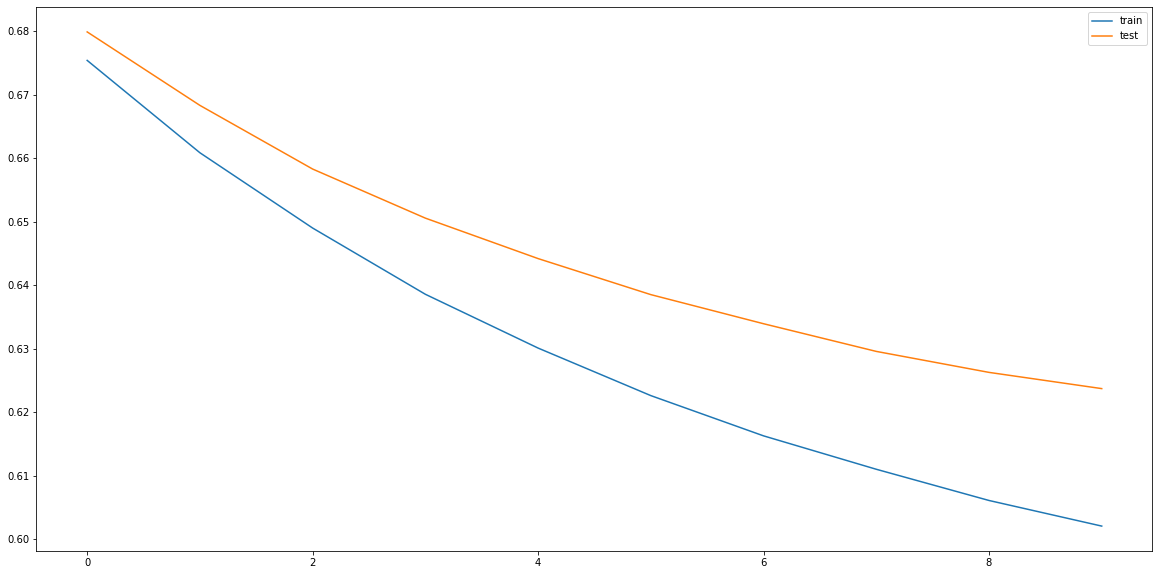

time: 799 ms (started: 2021-09-05 18:51:15 -04:00)


In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as pl
import xgboost as xgb
import sklearn.metrics
from matplotlib import pyplot

plt.rcParams["figure.figsize"] = (20,10)

X_train = train[all_sma_features]
X_test = test[all_sma_features]

# y_train = train['movl']
# y_test = test['movl']

y_train = train['home_win']
y_test = test['home_win']

evalset = [(X_train, y_train), (X_test,y_test)]

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'random_state': 1
}
xgb_model = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 1, 
                           learning_rate = 0.1,
                           max_depth = 5, 
                           alpha = 70,
                           n_estimators = 10,
                           gamma = 0.4,
                           min_child_weight=3,
                           random_state=1,
                           subsample=1,
                           eta = 0.1,
                           tree_method='gpu_hist',
                           use_label_encoder=False)

xgb_model.fit(X_train,y_train, eval_metric='logloss', eval_set =evalset, verbose=0)


# evaluate performance
yhat = xgb_model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = xgb_model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
y_pred = xgb.predict(X_test)
print(accuracy_score(y_test, y_pred))
xgb.predict_proba(X_test)

In [ ]:
preds = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f'RMSE: {rmse}')
preds = pd.Series(preds, name='xgb_movl')
pred_df = pd.concat([y_test.reset_index(drop=True), 
                preds.reset_index(drop=True),
               test['home_ml'].reset_index(drop=True),
               test['away_ml'].reset_index(drop=True)], axis=1)
pred_df['home_win'] = pred_df['movl'].map(lambda x: 0 if x < 0 else 1)
pred_df['xgb_home_win'] = pred_df['xgb_movl'].map(lambda x: 0 if x < 0 else 1)
pred_df['correct_pred'] = pred_df.apply(lambda x: 
    1 if x['home_win'] == x['xgb_home_win'] else 0, axis = 1)
acc = pred_df['correct_pred'].sum()/len(df.index)
print(f'Accuracy: {acc}')

In [ ]:
xgb.plot_importance(xgb_model)
pl.title("xgboost.plot_importance(model)")
pl.show()

## Accuracy of using just ML

In [ ]:
pred_df['ml_pred'] = pred_df.apply(lambda x: 
    1 if x['home_ml'] < x['away_ml'] else 0, axis = 1)

pred_df['ml_correct_pred'] = pred_df.apply(lambda x: 
    1 if x['home_win'] == x['ml_pred'] else 0, axis = 1)

acc = pred_df['ml_correct_pred'].sum()/len(df.index)
acc

## Tuning XGBoost

In [ ]:
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### TimeSeriesSplit

In [6]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as pl
import xgboost as xgb
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
time: 1.08 ms (started: 2021-09-05 18:51:26 -04:00)


### GridsearchCV

In [ ]:
class Tee(object):
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush() # If you want the output to be visible immediately
    def flush(self) :
        for f in self.files:
            f.flush()

In [ ]:
import sys

# logfile = open('xgb_tuning.txt', 'w')
# original_stderr = sys.stderr
# original_stdout = sys.stdout

# sys.stdout = Tee(sys.stdout, logfile)
# sys.stderr = sys.stdout

params = {
        'min_child_weight':[1, 2, 3, 10],
        'alpha':[30,70],
        'gamma':[0.05,0.1,1],
        'lambda':[1,10],
        'subsample':[0.6, 0.8, 1.0],
        'colsample_bytree':[0.4, 0.6, 0.8, 1.0],
        'max_depth':[6,10,20],
        'n_estimators':[2,3,5,20],
        'eta':[0.01,0.1,1]
        }
# grid_search = GridSearchCV(estimator = xgb_model, 
#                            cv = tscv, 
#                            scoring = 'neg_root_mean_squared_error',
#                            param_grid = params)
xgb_model = xgb.XGBClassifier(tree_method = 'gpu_hist', 
                              gpu_id = 0, 
                              eval_metric='logloss', 
                              random_state = 1,
                              use_label_encoder=False)
X_train = train[all_sma_features]
X_test = test[all_sma_features]

grid_search = GridSearchCV(estimator = xgb_model, 
                           cv = tscv, 
                           scoring = 'accuracy',
                           param_grid = params,
                           n_jobs = 1,
                           verbose=1)
grid_search.fit(X_train, y_train)

# sys.stdout = original_stdout
# sys.stderr = original_stderr
# logfile.close()






Fitting 3 folds for each of 20736 candidates, totalling 62208 fits


In [ ]:
import pickle
file_name = "xgb_sma_tuned.pkl"
# save
pickle.dump(grid_search.best_estimator_, open(file_name, "wb"))



In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))
grid_search.best_estimator_.predict_proba(X_test)

In [ ]:
params = {
        'min_child_weight':[1, 2, 3, 5, 7, 15,30],
        'alpha':[1,10,30,50,70,100],
        'gamma':[0.05, 0.1, 0.25, 0.5, 0.75],
        'lambda':[1,10,30,50],
        'subsample':[0.6, 0.8, 1.0],
        'colsample_bytree':[0.4, 0.6, 0.8, 1.0],
        'max_depth':[2,3,5, 7, 9],
        'n_estimators':[1,2,3,5,10,20],
        'eta':[0.1,0.3,0.5,0.7],
        'eval_metric':['logloss'],
        'random_state':[1],
        }
# grid_search = GridSearchCV(estimator = xgb_model, 
#                            cv = tscv, 
#                            scoring = 'neg_root_mean_squared_error',
#                            param_grid = params)
xgb_model = xgb.XGBClassifier(use_label_encoder=False)
X_train = train[all_ema_features]
X_test = test[all_ema_features]

grid_search = GridSearchCV(estimator = xgb_model, 
                           cv = tscv, 
                           scoring = 'roc_auc',
                           param_grid = params,
                           n_jobs = -1,
                           verbose=1)
grid_search.fit(X_train, y_train)
import pickle
file_name = "xgb_ema_tuned.pkl"
# save
pickle.dump(grid_search.best_estimator_, open(file_name, "wb"))

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))
grid_search.best_estimator_.predict_proba(X_test)

In [ ]:
cv_preds = grid_search.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, cv_preds))
print(f'RMSE: {rmse}')

pred_df['xgbcv_movl'] = cv_preds
pred_df['xgbcv_home_win'] = pred_df['xgbcv_movl'].map(lambda x: 0 if x < 0 else 1)
pred_df['correct_cv_pred'] = pred_df.apply(lambda x: 
     1 if x['home_win'] == x['xgbcv_home_win'] else 0, axis = 1)
acc = pred_df['correct_cv_pred'].sum()/len(df.index)
acc

### Save tuned model

In [ ]:
import pickle
file_name = "xgb_reg.pkl"
# save
pickle.dump(grid_search.best_estimator_, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [ ]:
xgb.plot_importance(xgb_model_loaded)
pl.title("xgboost.plot_importance(model)")
pl.show()

In [ ]:
for train_index, test_index in tscv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn import preprocessing

from sklearn import metrics


lr_train = train.replace([np.inf, -np.inf], np.nan).dropna(subset=all_features, how="any")

X_train = lr_train[all_features]
X_test = test[all_features]

y_train = lr_train['home_win']
y_test = test['home_win']

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

#print(X_test.mean(axis=0), X_test.std(axis=0))

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01, 0.001]

grid = dict(solver=solvers,penalty=penalty,C=c_values)


logreg=LogisticRegression(random_state=1,max_iter=1000)
logreg_cv=GridSearchCV(estimator=logreg,
                       param_grid=grid,
                       cv = tscv,
                       scoring='accuracy',
                       error_score=0,
                       verbose=1)

logreg_cv.fit(X_train, y_train)
lr_pred = logreg_cv.predict(X_test)



In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",logreg_cv.best_estimator_)
print("\n The best score across ALL searched params:\n",logreg_cv.best_score_)
print("\n The best parameters across ALL searched params:\n",logreg_cv.best_params_)
print("\n The test accuracy is:\n",metrics.accuracy_score(y_test, lr_pred))

from sklearn.linear_model import RidgeClassifier
## Ridge Regression

In [ ]:
from sklearn.linear_model import RidgeClassifier

ridge_train = train.replace([np.inf, -np.inf], np.nan).dropna(subset=all_features, how="any")

X_train = ridge_train[features]
X_test = test[features]

y_train = ridge_train['home_win']
y_test = test['home_win']

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)


ridge = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# define grid search
grid = dict(alpha=alpha)
grid_search = GridSearchCV(estimator=ridge, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=tscv, 
                           scoring='accuracy',
                           error_score=0,
                           verbose=1)
ridge_cv = grid_search.fit(X_train, y_train)
ridge_pred = ridge_cv.predict(X_test)


In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",ridge_cv.best_estimator_)
print("\n The best score across ALL searched params:\n",ridge_cv.best_score_)
print("\n The best parameters across ALL searched params:\n",ridge_cv.best_params_)
print("\n The test accuracy is:\n", metrics.accuracy_score(y_test, ridge_pred))

## Knn 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing


knn_train = train.replace([np.inf, -np.inf], np.nan).dropna(subset=all_sma_features, how="any")

X_train = knn_train[all_sma_features]
X_test = test[all_sma_features]

y_train = knn_train['home_win']
y_test = test['home_win']
              
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier()
n_neighbors = [1,5,10,50,100]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
          
grid = dict(n_neighbors=n_neighbors,
            weights=weights,
            metric=metric)
          
grid_search = GridSearchCV(estimator=knn, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=tscv, 
                           scoring='accuracy',
                           error_score=0)
knn_cv = grid_search.fit(X_train, y_train)
knn_pred = knn_cv.predict(X_test)
       


In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",knn_cv.best_estimator_)
print("\n The best score across ALL searched params:\n",knn_cv.best_score_)
print("\n The best parameters across ALL searched params:\n",knn_cv.best_params_)
print("\n The test accuracy is:\n", metrics.accuracy_score(y_test, knn_pred))

## SVM 

In [ ]:
from sklearn.svm import SVC

features = ['prev_home_elo', 'prev_away_elo', 
            'past_3_hth_home_bpm', 'past_3_hth_away_bpm', 
            'past_3_hth_home_per', 'past_3_hth_away_per',
            'past_3_hth_home_drtg', 'past_3_hth_away_drtg',
            'home_ml']


svm_train = train.replace([np.inf, -np.inf], np.nan).dropna(subset=features, how="any")

X_train = svm_train[features]
X_test = test[features]

y_train = svm_train['home_win']
y_test = test['home_win']


kernel = ['poly', 'rbf', 'sigmoid']
C = [500, 200, 100, 50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

grid = dict(kernel=kernel,
            C=C,
            gamma=gamma)

svm = SVC()

grid_search = GridSearchCV(estimator=svm, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=tscv, 
                           scoring='accuracy',
                           error_score=0)
svm_cv = grid_search.fit(X_train, y_train)
svm_pred = svm_cv.predict(X_test)
       


In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",svm_cv.best_estimator_)
print("\n The best score across ALL searched params:\n",svm_cv.best_score_)
print("\n The best parameters across ALL searched params:\n",svm_cv.best_params_)
print("\n The test accuracy is:\n", metrics.accuracy_score(y_test, svm_pred))

# ROC Curve

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = logreg_cv.predict_proba(X_test)
xgb_probs = xgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.plot(xgb_fpr, xgb_tpr, marker='.', label='XGB')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Strategy

In [ ]:
test['home_implied'] = test['home_ml'].map(lambda x: 1/x)
test['away_implied'] = test['away_ml'].map(lambda x: 1/x)
pred_probs = logreg_cv.predict_proba(X_test)
pred_probs

In [ ]:
cash = 100
i = 0
skip_bet = False
buffer = 0
for idx, row in test.iterrows():
    prev_cash = cash
    
    #bet_amount = min(0.02 * cash, 20000)
    bet_amount = 1
    cash -= bet_amount
    bet_home = 0
    if row['home_implied'] < pred_probs[i][1]:
        bet_home = 1
#     elif row['away_implied'] < pred_probs[i][0] + buffer:
#         bet_home = 0
#     else:
#         skip_bet = True
        
#     if skip_bet: 
#         skip_bet = False
#     el
    if row['home_win'] == 1 and bet_home:
        cash += bet_amount * row['home_ml'] 
    if row['home_win'] == 0 and not bet_home:
        cash += bet_amount * row['away_ml'] 

    i += 1
    test.at[idx, 'home_bet'] = bet_home
    test.at[idx, 'diff'] = cash - prev_cash
    test.at[idx, 'cash'] = cash
    test.at[idx, 'bet_amount'] = bet_amount

print(cash)



Bet on underdog if there is an edge

In [ ]:
cash = 100
i = 0
skip_bet = False
buffer = 0
for idx, row in test.iterrows():
    prev_cash = cash
    #bet_amount = min(0.02 * cash, 20000)
    bet_amount = 1
    if row['home_implied'] < row['away_implied']:
        if row['home_implied'] < pred_probs[i][1] + buffer:
            bet_home = 1
        else:
            bet_home = 0
    else:
        if row['away_implied'] < pred_probs[i][0] + buffer:
            bet_home = 0
        else:
            bet_home = 1
    cash -= bet_amount

#     elif row['away_implied'] < pred_probs[i][0] + buffer:
#         bet_home = 0
#     else:
#         skip_bet = True
        
#     if skip_bet: 
#         skip_bet = False
#     el
    if row['home_win'] == 1 and bet_home:
        cash += bet_amount * row['home_ml'] 
    if row['home_win'] == 0 and not bet_home:
        cash += bet_amount * row['away_ml'] 

    i += 1
    test.at[idx, 'home_bet'] = bet_home
    test.at[idx, 'diff'] = cash - prev_cash
    test.at[idx, 'cash'] = cash
    test.at[idx, 'bet_amount'] = bet_amount

print(cash)


In [ ]:
cash = 1000
i = 0
skip_bet = False
buffer = 0
for idx, row in test.iterrows():
    prev_cash = cash
    bet_amount = min(0.02 * cash, 20000)
    #bet_amount = 1
    cash -= bet_amount
    bet_home = 0
    if  pred_probs[i][0] < pred_probs[i][1] + buffer and row['home_implied'] < pred_probs[i][1]:
        bet_home = 1
#     elif row['away_implied'] < pred_probs[i][0] + buffer:
#         bet_home = 0
#     else:
#         skip_bet = True
        
    if skip_bet: 
        skip_bet = False
    elif row['home_win'] == 1 and bet_home:
        cash += bet_amount * row['home_ml'] 
    elif row['home_win'] == 0 and not bet_home:
        cash += bet_amount * row['away_ml'] 

    i += 1
    test.at[idx, 'home_bet'] = bet_home
    test.at[idx, 'diff'] = cash - prev_cash
    test.at[idx, 'cash'] = cash
    test.at[idx, 'bet_amount'] = bet_amount

print(cash)


In [ ]:
cash = 100
i = 0
skip_bet = False
buffer = 0
for idx, row in test.iterrows():
    prev_cash = cash
    #bet_amount = max(min(0.05 * cash, 20000),1)
    bet_amount = 1
    cash -= bet_amount
    bet_home = 0
    if row['home_implied'] > row['away_implied']:
        bet_home = 1
#     elif row['away_implied'] < pred_probs[i][0] + buffer:
#         bet_home = 0
#     else:
#         skip_bet = True
        
    if skip_bet: 
        skip_bet = False
    elif row['home_win'] == 1 and bet_home:
        cash += bet_amount * row['home_ml'] 
    elif row['home_win'] == 0 and not bet_home:
        cash += bet_amount * row['away_ml'] 

    i += 1
    test.at[idx, 'home_bet'] = bet_home
    test.at[idx, 'diff'] = cash - prev_cash
    test.at[idx, 'cash'] = cash
    test.at[idx, 'bet_amount'] = bet_amount

print(cash)



In [ ]:
import plotly.express as px
from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
bokeh.io.output_notebook(INLINE)

def plot_pnl(df):
#     output_notebook()
#     plot = figure(title="Profit and Loss", x_axis_label="Date", y_axis_label="Account Balance", 
#                   x_axis_type = 'datetime', plot_width=800, plot_height=500)

#     y = df['cash'].tolist()
#     x = df['date'].tolist()

#     plot.circle(x, y, legend_label='Cash',  line_color = 'blue', line_width = 1)

#     handle = show(plot, notebook_handle=True)

#     # Update the plot title in the earlier cell
#     push_notebook(handle=handle)

    fig = px.scatter(x =df['date'], y=df["cash"], title='Account Balance')
    fig.show()

plot_pnl(test)


In [ ]:
test['home_pred'] = [i[1] for i in pred_probs]
test['won_bet'] = test['diff'].apply(lambda x: 1 if x > 0 else 0)
check = test[['date', 'home_implied', 'home_pred','away_implied', 'home_bet', 'cash', 'diff','bet_amount', 
               'home_ml', 'away_ml', 'home_win' ]].copy()
print(f'''bets won: {test['won_bet'].sum()} / {len(test)} = {test['won_bet'].sum()/len(test)}''')

In [ ]:
biggestwins = test[test['diff']>2]['diff']

In [ ]:
underdogs = check[( ((check['home_implied'] < check['away_implied']) & (check['home_bet']==1))
                   | ((check['home_implied'] > check['away_implied']) & (check['home_bet']==0)))]

In [ ]:
check['diff'].describe()

In [ ]:
favorites = test[(test['diff']<0.3) & (test['diff']>0)]['diff']

In [ ]:
favorites.sum()

In [ ]:
biggestwins.sum()

In [ ]:
y_train[y_train == 1]

In [ ]:

len(y_train[y_train == 1]) / len(y_train)